# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather
conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
   - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
   - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip

Note that even if we are estimating a time serie, we are not using
here a recurrent neural network as we assume the temporal dependence
to be negligible (i.e. Y_t = f(X_t) alone).

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

import Random
Random.seed!(123);

 Activating environment at `~/Dropbox/Julia7/MLJ/MLJ/sandbox/betaml/Project.toml`


Loading cleaned version of the data:

In [2]:
using UrlDownload, ZipFile, PooledArrays, DataFrames, CSV
location = "https://www.hds.utc.fr/~tdenoeux/"*
    "dokuwiki/_media/en/bike_sharing_day.csv.zip"
data = DataFrame(urldownload(location));
describe(data)

┌ Warning: More than one file in zip archive, returning first.
└ @ UrlDownload /Users/anthony/.julia/packages/UrlDownload/t5kcg/src/UrlDownload.jl:310


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,instant,366.0,1,366.0,731,0,Int64
2,dteday,,2011-01-01,,2012-12-31,0,Date
3,season,2.49658,1,3.0,4,0,Int64
4,yr,0.500684,0,1.0,1,0,Int64
5,mnth,6.51984,1,7.0,12,0,Int64
6,holiday,0.0287278,0,0.0,1,0,Int64
7,weekday,2.99726,0,3.0,6,0,Int64
8,workingday,0.683995,0,1.0,1,0,Int64
9,weathersit,1.39535,1,1.0,3,0,Int64


The target `y` is the `:cnt` column. The features, `x`, are to include everything that's left, excluding `:dteday`, `:casual`, and `:registered`:

In [3]:
using MLJ
y, x = unpack(data,
              ==(:cnt),
              name -> !(name in [:dteday, :casual, :registered]));

Inspecting the interpretation of the data as currently represented:

In [4]:
schema(x)

┌────────────┬─────────┬────────────┐
│ _.names    │ _.types │ _.scitypes │
├────────────┼─────────┼────────────┤
│ instant    │ Int64   │ Count      │
│ season     │ Int64   │ Count      │
│ yr         │ Int64   │ Count      │
│ mnth       │ Int64   │ Count      │
│ holiday    │ Int64   │ Count      │
│ weekday    │ Int64   │ Count      │
│ workingday │ Int64   │ Count      │
│ weathersit │ Int64   │ Count      │
│ temp       │ Float64 │ Continuous │
│ atemp      │ Float64 │ Continuous │
│ hum        │ Float64 │ Continuous │
│ windspeed  │ Float64 │ Continuous │
└────────────┴─────────┴────────────┘
_.nrows = 731


In [5]:
scitype(y)

AbstractArray{Count,1}

Coercing type of `y` to get appropriate interpretation:

In [6]:
y = coerce(y, Continuous);

Optional: look for all supervised models that apply to this data:

In [7]:
models(matching(x, y))

5-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = ConstantRegressor, package_name = MLJModels, ... )
 (name = DecisionTreeRegressor, package_name = DecisionTree, ... )
 (name = DeterministicConstantRegressor, package_name = MLJModels, ... )
 (name = RandomForestRegressor, package_name = DecisionTree, ... )
 (name = RandomForestRegressor, package_name = ScikitLearn, ... )

Splitting the data into train, validation and test sets:

In [8]:
train, val, test = partition(eachindex(y), 0.75, 0.125);
xtrain    = x[train, :]
ytrain    = y[train]
xval      = x[val, :]
yval      = y[val]
xtest     = x[test, :]
ytest     = y[test];

## Decision Trees

Loading the model code (a default instance is returned):

In [9]:
tree_model = @load DecisionTreeRegressor pkg=DecisionTree

DecisionTreeRegressor(
    max_depth = -1,
    min_samples_leaf = 5,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0) @667

Note that a model is just a struct containing hyperparameters. The
learned parameters (in this case a tree) called `tree` below.

### Tuning `max_depth` (by hand, using a holdout set - no cross validation)

In [10]:
function findBestDepth(xtrain, ytrain, xval, yval, attemptedDepths)
    best_depth = 1
    best_error   = +Inf
    for ad in attemptedDepths
        tree_model.max_depth = ad
        tree, _ = MLJ.fit(tree_model, 0, xtrain, ytrain) # verbosity=0
        ŷval   = MLJ.predict(tree_model, tree, xval)
        mean_proportional_error = mape(ŷval, yval)
        println("$ad : $mean_proportional_error")
        if mean_proportional_error < best_error
            best_depth = ad
            best_error   = mean_proportional_error
        end
    end
    return (best_depth, best_error)
end

findBestDepth (generic function with 1 method)

In [11]:
best_depth, best_error = findBestDepth(xtrain, ytrain, xval, yval, 1:20)

1 : 0.2795727949692381
2 : 0.13440709867155348
3 : 0.11543645357414804
4 : 0.09823897896834381
5 : 0.11217677533677815
6 : 0.10852004326151618
7 : 0.1090274947630564
8 : 0.10902994849011698
9 : 0.10660359192818873
10 : 0.10677068935190083
11 : 0.10677068935190083
12 : 0.10677068935190083
13 : 0.10677068935190083
14 : 0.10677068935190083
15 : 0.10677068935190083
16 : 0.10677068935190083
17 : 0.10677068935190083
18 : 0.10677068935190083
19 : 0.10677068935190083
20 : 0.10677068935190083


(4, 0.09823897896834381)

Re-training the best model on the train set:

In [12]:
model = DecisionTreeRegressor(max_depth=best_depth)
tree, _ = MLJ.fit(model, 1, xtrain, ytrain)

(Decision Tree
Leaves: 15
Depth:  4, nothing, nothing)

In [13]:
ŷtrain = MLJ.predict(model, tree, xtrain)
ŷval   = MLJ.predict(model, tree, xval)
ŷtest  = MLJ.predict(model, tree, xtest);

In [14]:
@show mape(ŷtrain, ytrain) mape(ŷval, yval) mape(ŷtest, ytest)

mape(ŷtrain, ytrain) = 0.18979972188842917
mape(ŷval, yval) = 0.09823897896834381
mape(ŷtest, ytest) = 2.4716626026894897


2.4716626026894897

In [15]:
using StatsPlots
pyplot()

Plots.PyPlotBackend()

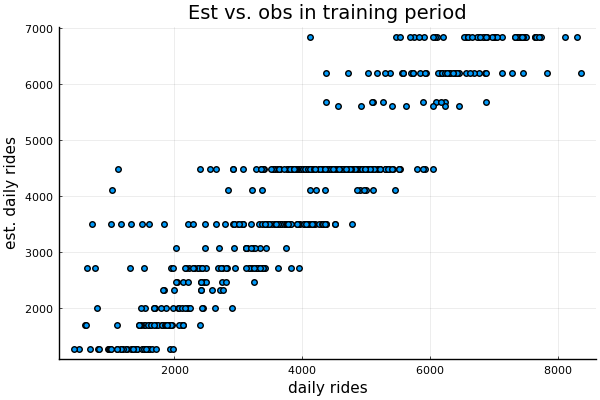

In [16]:
scatter(ytrain,
        ŷtrain,
        xlabel="daily rides",
        ylabel="est. daily rides",
        label=nothing,
        title="Est vs. obs in training period")

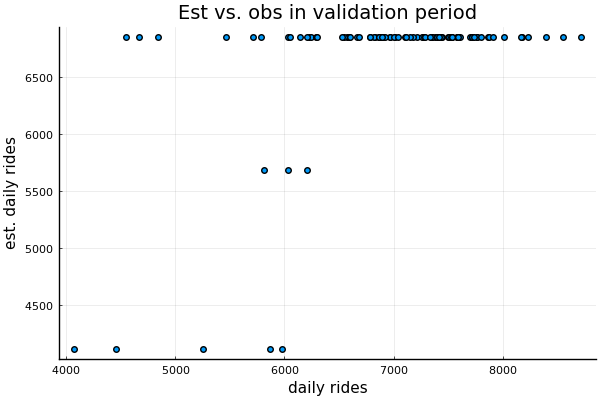

In [17]:
scatter(yval,ŷval,
        xlabel="daily rides",
        ylabel="est. daily rides",
        label=nothing,
        title="Est vs. obs in validation period")

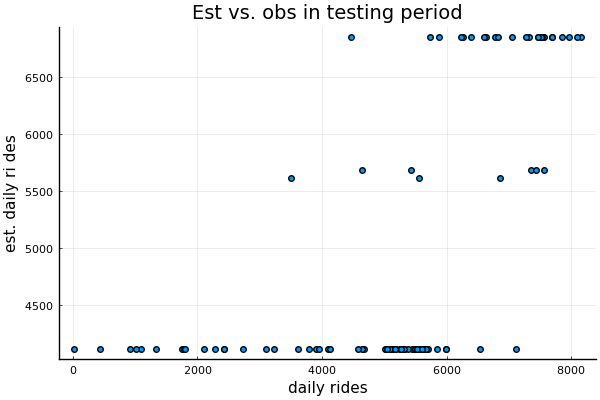

In [18]:
scatter(ytest,
        ŷtest,
        xlabel="daily rides",
        ylabel="est. daily ri des",
        label=nothing,
        title="Est vs. obs in testing period")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*